# Assignment 5.11 Final Project EDA
**DS 5110**  
February 27, 2022  
Carly Kelly, Kin Girma, Brooks Anderson

---
We begin by initializing a spark session and reading in our dataset. Some initial data-cleaning was performed previously.

In [1]:
import os

os.chdir("/project/ds5559/CollegeScorecard/")

# create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master("local") \
        .appName("EDA_brooks") \
        .getOrCreate()
sc = spark.sparkContext

In [2]:
# necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [3]:
# read in file
data = spark.read.csv("intermediate_data.csv", inferSchema = True, header = True)

In [4]:
# preview dataframe
id_Cols = ['UNITID', 'INSTNM','MAIN']
interest_predictors = ['CONTROL',
 'LOCALE',
 'UGDS',
 'GRADS',
 'ADM_RATE_imputed',
 'COSTT4_A_imputed',
 'AVGFACSAL_imputed',
 'INEXPFTE',
 'PCIP14',
 'PCIP15']
interest_Cols = id_Cols + interest_predictors

data.select(interest_Cols).show(5, truncate=False)

+------+-----------------------------------+----+-------+------+-----+-----+----------------+----------------+-----------------+--------+------+------+
|UNITID|INSTNM                             |MAIN|CONTROL|LOCALE|UGDS |GRADS|ADM_RATE_imputed|COSTT4_A_imputed|AVGFACSAL_imputed|INEXPFTE|PCIP14|PCIP15|
+------+-----------------------------------+----+-------+------+-----+-----+----------------+----------------+-----------------+--------+------+------+
|100654|Alabama A & M University           |1   |1      |12    |4930 |874  |0.5129          |13762.0         |6603.0           |6601    |0.0957|0.0375|
|100663|University of Alabama at Birmingham|1   |1      |12    |10661|6515 |0.8243          |18003.0         |9000.0           |16090   |0.0552|0.0   |
|100690|Amridge University                 |1   |2      |12    |370  |379  |0.7143          |20700.0         |3400.0           |4879    |0.0   |0.0   |
|100706|University of Alabama in Huntsville|1   |1      |12    |5828 |1609 |0.6614      

## Number of Records

In [5]:
data.count()

16450

## Number of Columns

In [6]:
len(data.columns)

118

This includes 3 identifcation columns and 1 response column. Thus, we have 114 feature columns to start.

## Statistical Summary of Response Variable
Our response variable is `DEBT_MDN`, median debt upon graduation.

In [7]:
# cast to float
data = data.withColumn('DEBT_MDN', data.DEBT_MDN.cast('float'))

data.select('DEBT_MDN').describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
DEBT_MDN,16450,15067.056869300912,5059.659830553921,1550.0,39581.0


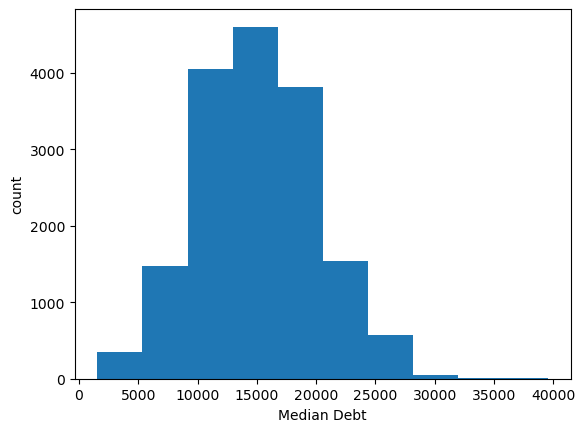

In [8]:
# plot histogram of response variale
data_pandas = data.select('DEBT_MDN').toPandas()

plt.hist(data_pandas['DEBT_MDN'])
plt.xlabel('Median Debt')
plt.ylabel('count')
plt.show()


## Statistical Summary of Predictors
We previously selected 10 interesting predictors.

In [9]:
data.select(interest_predictors).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
CONTROL,16450,1.7117933130699088,0.5306928276638436,1,3
LOCALE,16450,19.842553191489362,9.507612075762301,11,43
UGDS,16450,5127.659088145897,7436.411105278192,2,98630
GRADS,16450,1598.7068693009119,3139.2403837413412,0,44560
ADM_RATE_imputed,16450,0.6512291306990668,0.18419253735619523,0.0,1.0
COSTT4_A_imputed,16450,33293.7379331307,14243.152552005002,5033.0,78555.0
AVGFACSAL_imputed,16450,7451.627781155015,2320.5213027542245,269.0,26084.0
INEXPFTE,16450,10730.17179331307,10364.915347209177,0,171547
PCIP14,16450,0.0295939513677811,0.09068682929314652,0.0,1.0


In [10]:
# quantiles
numerical_predictors = ['UGDS', 'GRADS', 'ADM_RATE_imputed', 'COSTT4_A_imputed',
                        'AVGFACSAL_imputed','INEXPFTE', 'PCIP14', 'PCIP15']
quartiles = data.approxQuantile(col = numerical_predictors,
                                probabilities = [0.25, 0.5, 0.75],
                                relativeError = 0.00001)

clean_quartiles = pd.DataFrame({numerical_predictors[i]:quartiles[i] for i in range(len(quartiles))})
clean_quartiles.index = ["25", "50", "75"]
clean_quartiles

,UGDS,GRADS,ADM_RATE_imputed,COSTT4_A_imputed,AVGFACSAL_imputed,INEXPFTE,PCIP14,PCIP15
25,1051.0,52.0,0.5554,21321.0,5956.0,6335.0,0.0000,0.0
50,2134.0,469.0,0.6691,31374.0,7130.0,8377.0,0.0000,0.0
75,5797.0,1714.0,0.7694,42906.0,8612.0,11585.0,0.0094,0.0


### Summarize Categoricals
`CONTROL` and `LOCALE` are categoricals

In [11]:
# CONTROL summary
CONTROL_summary = data.groupBy(data.CONTROL).agg(F.count(data.CONTROL).alias('CONTROL_count'))
CONTROL_summary.withColumn('pct', (CONTROL_summary.CONTROL_count / data.count())*100).show()

+-------+-------------+-----------------+
|CONTROL|CONTROL_count|              pct|
+-------+-------------+-----------------+
|      1|         5370|32.64437689969605|
|      3|          629| 3.82370820668693|
|      2|        10451|63.53191489361703|
+-------+-------------+-----------------+



In [12]:
# LOCALE Summary
LOCALE_summary = data.groupBy(data.LOCALE).agg(F.count(data.LOCALE).alias('LOCALE_count'))
LOCALE_summary.withColumn('pct', (LOCALE_summary.LOCALE_count / data.count())*100).show()

+------+------------+------------------+
|LOCALE|LOCALE_count|               pct|
+------+------------+------------------+
|    31|         610| 3.708206686930091|
|    12|        2070|12.583586626139818|
|    22|         490|2.9787234042553195|
|    13|        2320|14.103343465045592|
|    41|         450| 2.735562310030395|
|    43|         140| 0.851063829787234|
|    23|         330|2.0060790273556233|
|    21|        2990| 18.17629179331307|
|    32|        1750|10.638297872340425|
|    33|        1100|  6.68693009118541|
|    11|        3930|23.890577507598785|
|    42|         270|1.6413373860182372|
+------+------------+------------------+

